# Predicting the sucess of telemarketing campaigns

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,classification_report, f1_score

In [2]:
from src.performance_metrics import plot_confusion_matrix, auc_score
from src.fit_model import fit_XGBoost


# Exploratory data analysis

In [3]:
data=pd.read_csv('bank.csv',sep=';')

In [4]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [5]:
# 1. Basic Overview
print("Shape of the dataset:", data.shape)
print("\nColumn Data Types:")
print(data.info())


Shape of the dataset: (4521, 17)

Column Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None



Target Variable Distribution:
y
no     0.88476
yes    0.11524
Name: proportion, dtype: float64


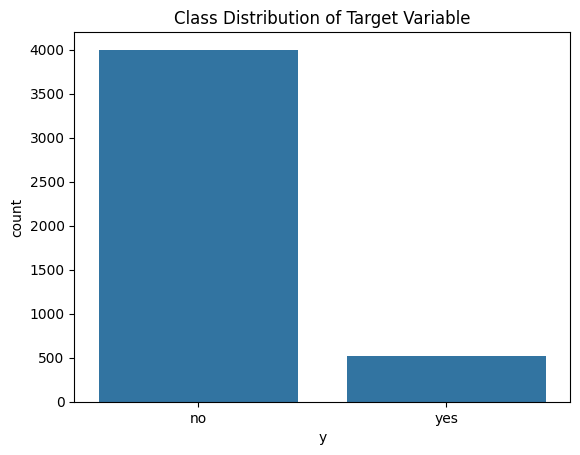

In [6]:
# 2. Target Variable Analysis
print("\nTarget Variable Distribution:")
print(data['y'].value_counts(normalize=True))

# Plot class distribution
sns.countplot(data=data, x='y')
plt.title("Class Distribution of Target Variable")
plt.show()

In [7]:
data['y'] = data['y'].replace({'yes': 1, 'no': 0})
data['default'] = data['default'].replace({'yes': 1, 'no': 0})
data['housing'] = data['housing'].replace({'yes': 1, 'no': 0})
data['loan'] = data['loan'].replace({'yes': 1, 'no': 0})

In [8]:
# looking at the numerical columns
numerical_data = data.select_dtypes(include=['number'])
categorical_data=data.select_dtypes(include=['object'])
numerical_data_copy=numerical_data.copy()
numerical_data['y']=data['y']

In [9]:
# Grouped Analysis
print("\nMean Values Grouped by Target Variable:")
print(numerical_data.groupby('y').mean())

print("\nMedian Values Grouped by Target Variable:")
print(numerical_data.groupby('y').median())



Mean Values Grouped by Target Variable:
         age   default      balance   housing      loan        day  \
y                                                                    
0  40.998000  0.016750  1403.211750  0.584750  0.162000  15.948750   
1  42.491363  0.017274  1571.955854  0.422265  0.082534  15.658349   

     duration  campaign      pdays  previous  
y                                             
0  226.347500  2.862250  36.006000  0.471250  
1  552.742802  2.266795  68.639155  1.090211  

Median Values Grouped by Target Variable:
    age  default  balance  housing  loan   day  duration  campaign  pdays  \
y                                                                           
0  39.0      0.0    419.5      1.0   0.0  16.0     167.0       2.0   -1.0   
1  40.0      0.0    710.0      0.0   0.0  15.0     442.0       2.0   -1.0   

   previous  
y            
0       0.0  
1       0.0  


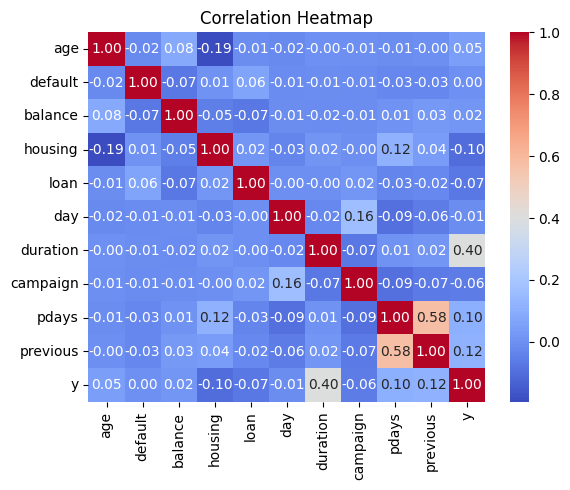

In [10]:
sns.heatmap(numerical_data_copy.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

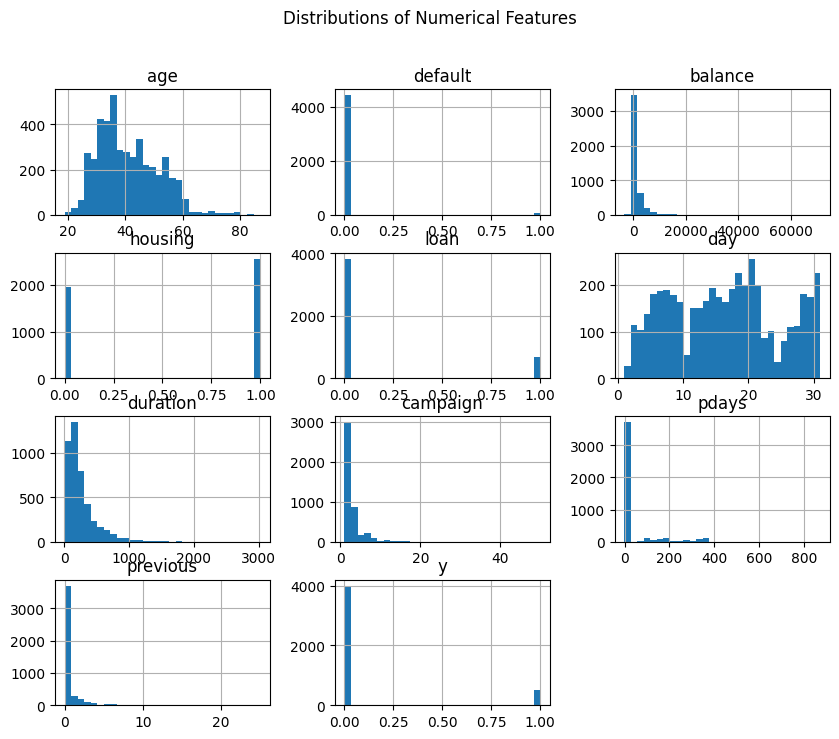

In [11]:
numerical_data_copy.hist(bins=30, figsize=(10, 8))
plt.suptitle("Distributions of Numerical Features")
plt.show()


Value Counts for job:
job
management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: count, dtype: int64


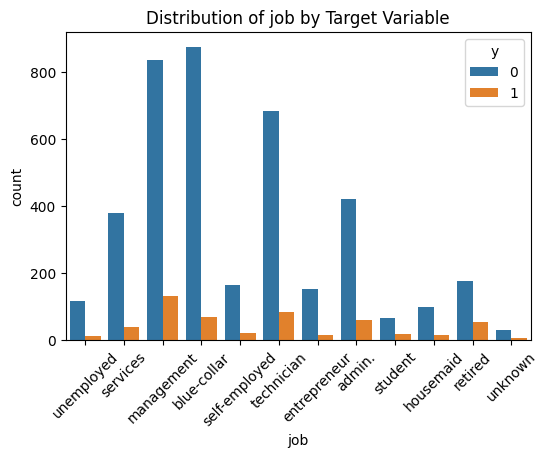


Value Counts for marital:
marital
married     2797
single      1196
divorced     528
Name: count, dtype: int64


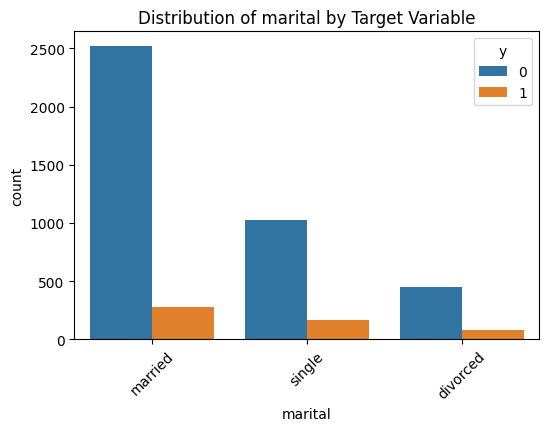


Value Counts for education:
education
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: count, dtype: int64


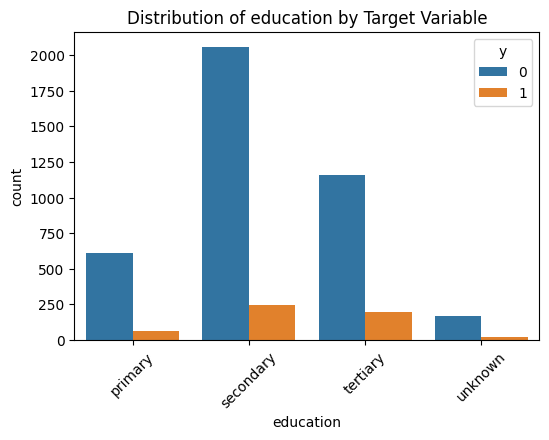


Value Counts for contact:
contact
cellular     2896
unknown      1324
telephone     301
Name: count, dtype: int64


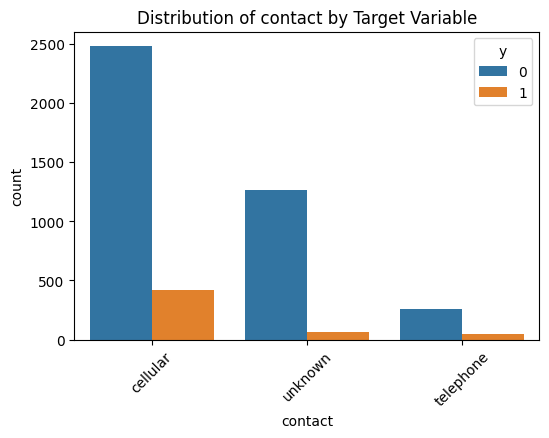


Value Counts for month:
month
may    1398
jul     706
aug     633
jun     531
nov     389
apr     293
feb     222
jan     148
oct      80
sep      52
mar      49
dec      20
Name: count, dtype: int64


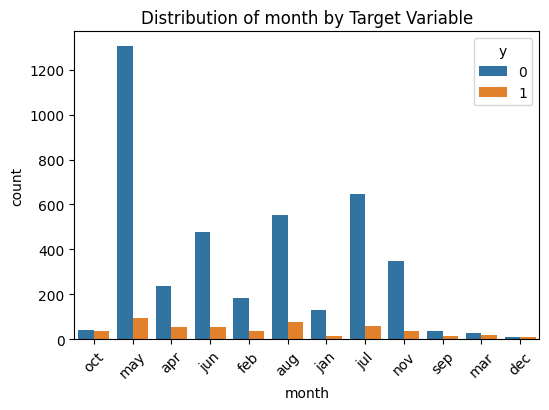


Value Counts for poutcome:
poutcome
unknown    3705
failure     490
other       197
success     129
Name: count, dtype: int64


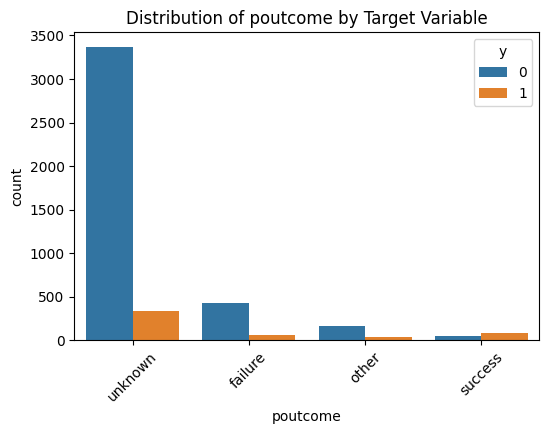

In [12]:
categorical_columns=categorical_data.columns
for col in categorical_columns:
    print(f"\nValue Counts for {col}:")
    print(data[col].value_counts())
    
    # Plot distribution with target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=col, hue='y')
    plt.title(f"Distribution of {col} by Target Variable")
    plt.xticks(rotation=45)
    plt.show()

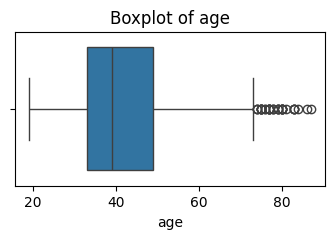

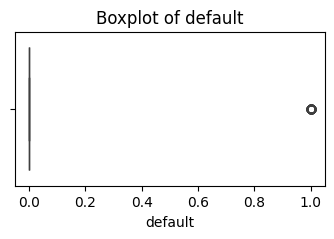

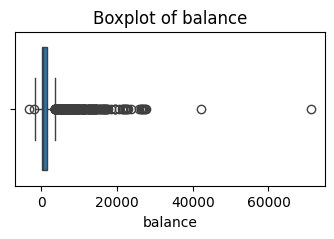

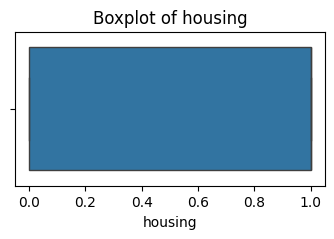

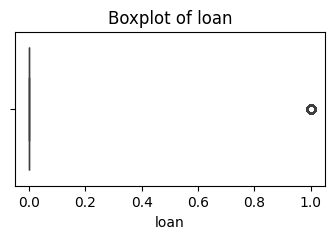

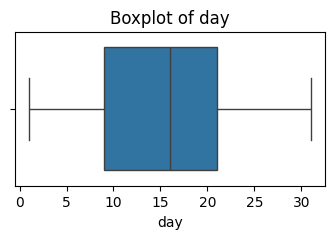

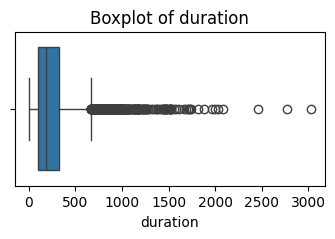

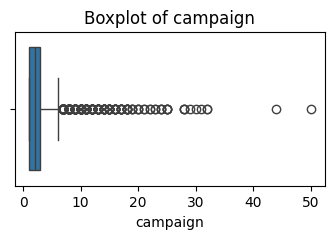

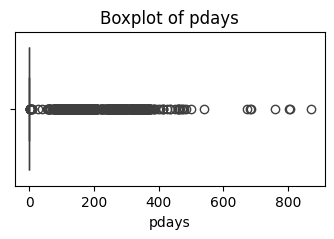

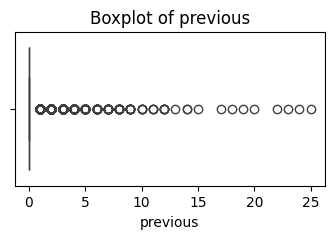

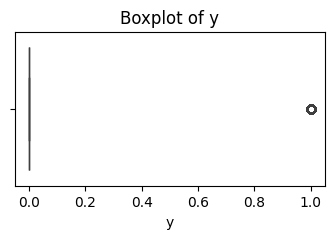

In [13]:
# 5. Outlier Detection
numerical_columns = numerical_data_copy.columns
for col in numerical_columns:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [14]:
# 6. Missing or Unknown Values
print("\nMissing Values:")
print(data.isnull().sum())

print("\n'Unknown' Values:")
for col in categorical_columns:
    print(f"{col}: {data[col].isin(['unknown']).sum()} unknown values")



Missing Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

'Unknown' Values:
job: 38 unknown values
marital: 0 unknown values
education: 187 unknown values
contact: 1324 unknown values
month: 0 unknown values
poutcome: 3705 unknown values


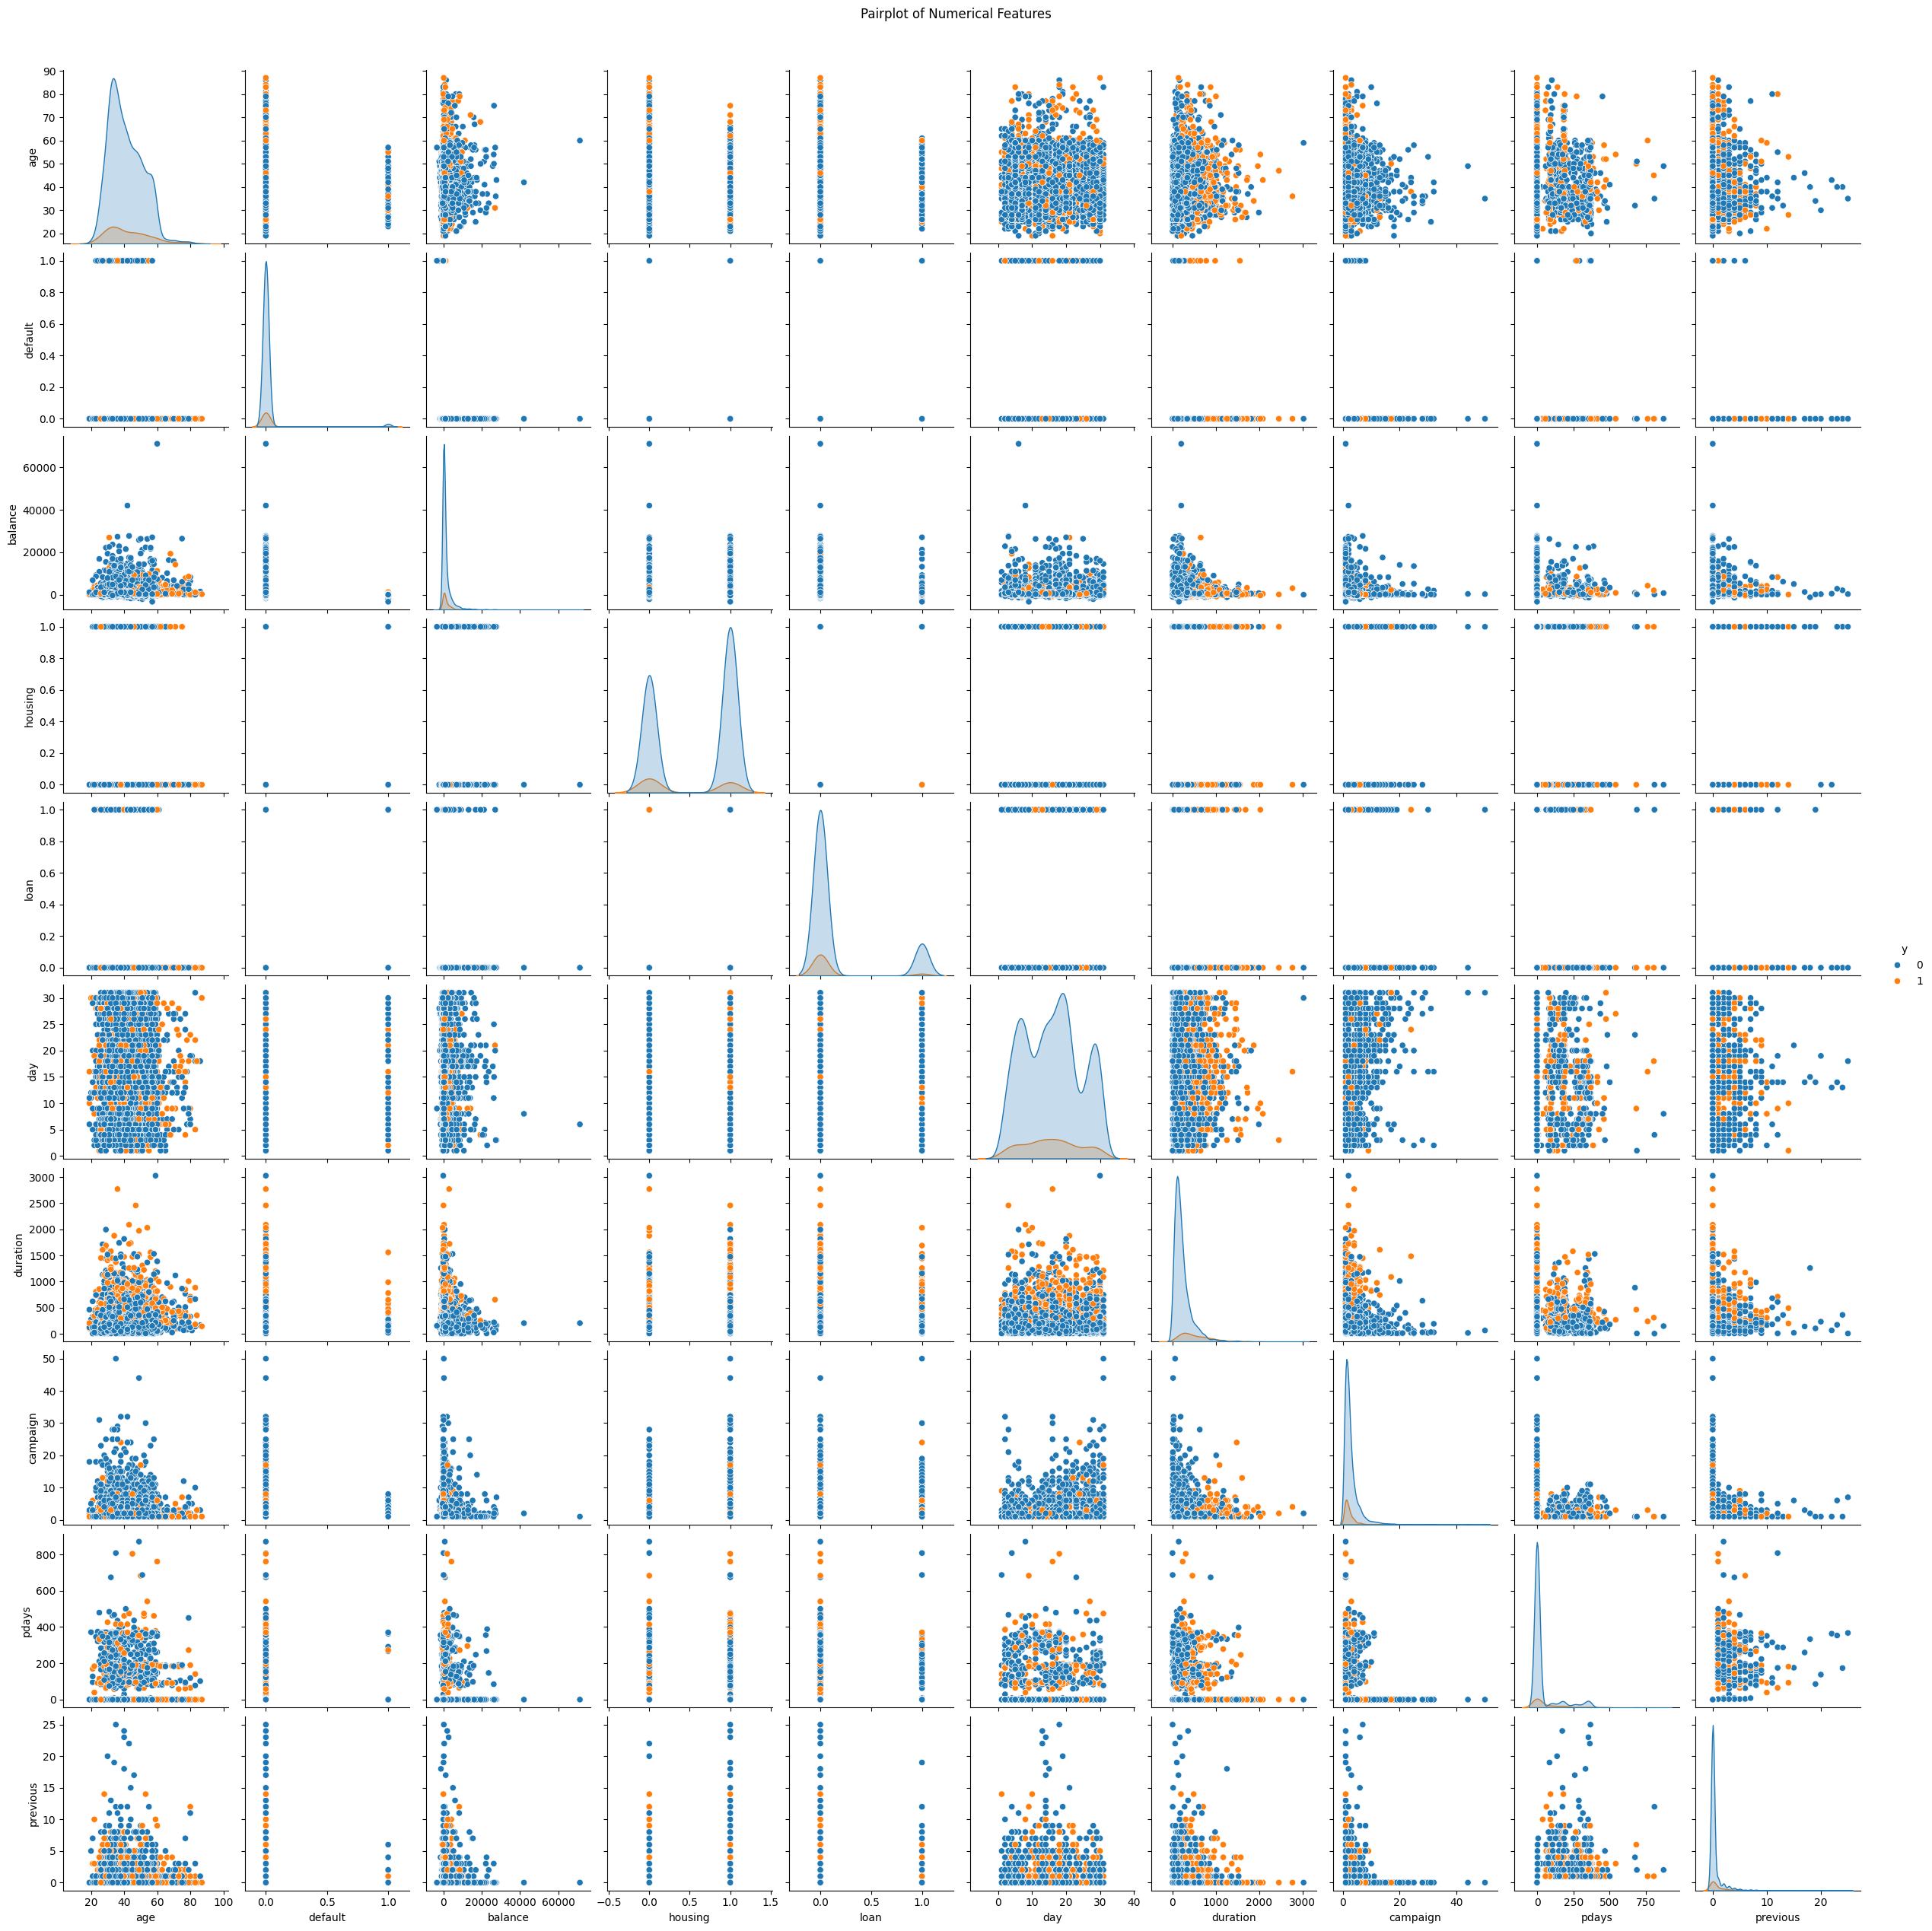

In [15]:
# 7. Feature Relationships
# Pairplot for numerical features
sns.pairplot(data, hue='y', diag_kind='kde')
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


All the columns of interests (i.e diagonal plot) has the predictive power (as none of them are uniform).

One Hot Encoding

In [17]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data_encoded = pd.concat([data, one_hot_df], axis=1)
data_encoded = data_encoded.drop(categorical_columns, axis=1)

In [18]:
data_encoded

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,33,0,4789,1,1,11,220,1,339,4,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,35,0,1350,1,0,16,185,1,330,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,30,0,1476,1,1,3,199,4,-1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,59,0,0,1,0,5,226,1,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,0,-333,1,0,30,329,5,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4517,57,1,-3313,1,1,9,153,1,-1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4518,57,0,295,0,0,19,151,11,-1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4519,28,0,1137,0,0,6,129,4,211,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# XGBoost

In [19]:
X =  data_encoded.drop(['y','duration','previous'], axis=1)
y = data_encoded['y']

In [20]:
feature_map = {f'f{i}': name for i, name in enumerate(X.columns)}

In [21]:
# Scaling the features

scaler=StandardScaler()
X=scaler.fit_transform(X)

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [23]:
# parameters to CV
params = {
    
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5, 1]
}


In [28]:
# ratio of negative to positive samples
neg_pos_ratio=np.round((len(y_train)-y_train.sum())/y_train.sum(),2)

In [29]:
weights=np.array([1,5,neg_pos_ratio, 50,100,1000])

In [30]:
models={}
for i in range(len(weights)):
    print(weights[i])
    models[weights[i]]=fit_XGBoost(X_train,y_train,params, scoring_metric='f1',scale_pos_weight=weights[i])


1.0
5.0
7.84
50.0
100.0
1000.0


Text(0.5, 1.0, 'ROC Curve')

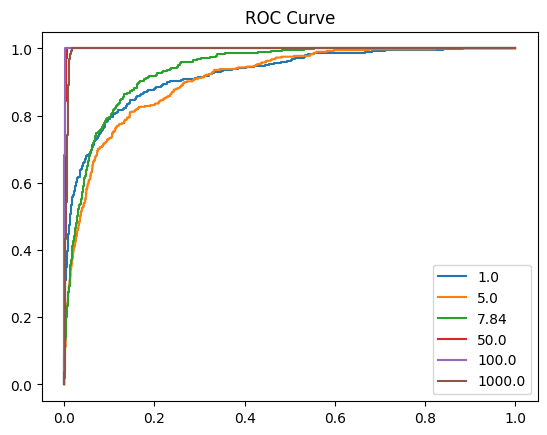

In [31]:
for i in range(len(weights)):
    best_clf=models[weights[i]]
    pred = best_clf.predict(X_train)
    y_pred_prob = best_clf.predict_proba(X_train)
    fpr, tpr, _ = roc_curve(y_train,y_pred_prob[:,1])
    plt.plot(fpr,tpr, label=weights[i])

plt.legend()
plt.title('ROC Curve')

In [32]:
for i in range(len(weights)):
    best_clf=models[weights[i]]
    pred = best_clf.predict(X_train)
    y_pred_prob = best_clf.predict_proba(X_train)
    print(f"for weight={weights[i] } the auc score is {auc_score(y_train, y_pred_prob[:,1])}")

for weight=1.0 the auc score is 0.7281413429539806
for weight=5.0 the auc score is 0.6220421533898678
for weight=7.84 the auc score is 0.6591226954069568
for weight=50.0 the auc score is 0.9781027355871887
for weight=100.0 the auc score is 0.9962041800810442
for weight=1000.0 the auc score is 0.9425320901854387


In [33]:
for i in range(len(weights)): # f1 score
    best_clf=models[weights[i]]
    pred = best_clf.predict(X_train)

    print(f'weight={weights[i]}')
    print(classification_report(y_train, pred))
    

weight=1.0
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3207
           1       0.91      0.35      0.50       409

    accuracy                           0.92      3616
   macro avg       0.91      0.67      0.73      3616
weighted avg       0.92      0.92      0.91      3616

weight=5.0
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3207
           1       0.55      0.68      0.61       409

    accuracy                           0.90      3616
   macro avg       0.76      0.81      0.78      3616
weighted avg       0.91      0.90      0.91      3616

weight=7.84
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3207
           1       0.45      0.86      0.59       409

    accuracy                           0.87      3616
   macro avg       0.72      0.86      0.76      3616
weighted avg       0.92      0.87      0

We find the best model for weight= 100 (it has the best f1 score)

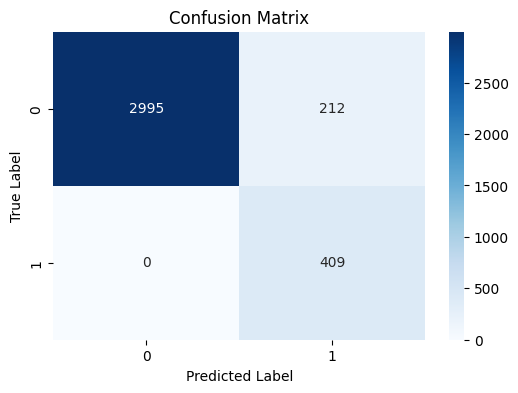

In [34]:
plot_confusion_matrix(y_train,models[weights[4]].predict(X_train),class_names=[0,1])

It correctly classifies all the clients that would buy a CD.

# Feauteres selection

We look at the most important features of the best model previously found.

In [39]:
best_clf=models[weights[4]]

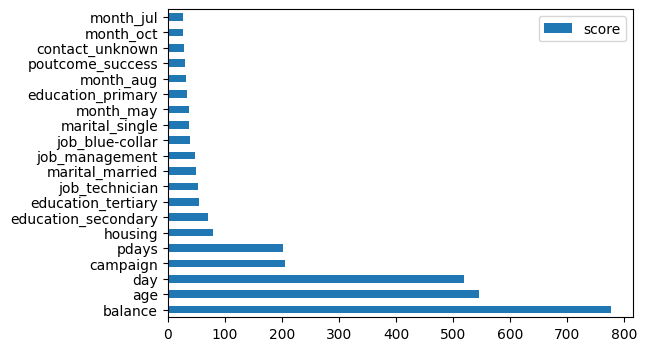

In [41]:
feature_important = best_clf.get_booster().get_score(importance_type='weight')
# Replace keys in feature_important with original feature names
feature_important_named = {feature_map[key]: value for key, value in feature_important.items()}

# Create DataFrame for visualization
data = pd.DataFrame(data=feature_important_named.values(), index=feature_important_named.keys(), columns=["score"])
data = data.sort_values(by="score", ascending=False)

# Plot the top 20 features
data.nlargest(20, columns="score").plot(kind='barh', figsize=(6, 4))
plt.show()

In [42]:
def X_y_feature_selec(nb_features):
    ''''''
    X =  data_encoded.drop(['y','duration','previous'], axis=1)
    y = data_encoded['y']
    top_features = data.nlargest(nb_features, columns="score").index.tolist()
    X=X[top_features]
    return X,y


We select the most important n features (n in nb_features) and we train the model with only these features. We find the best weight. 
We do this for all n in nb_features and we select the model with the best f1 score.

In [ ]:
nb_features=[5,10,15,20,25]
feat=0
weight=0
f_score=0
for nb in nb_features:
    X,y=X_y_feature_selec(nb_features=nb)
    X_train_feat_selec, X_test_feat_selec, y_train_feat_selec, y_test_feat_selec = train_test_split(X, y, test_size=0.2, random_state=0)
    for i in range(len(weights)):
        model=fit_XGBoost(X_train_feat_selec,y_train_feat_selec,params, scoring_metric='f1',scale_pos_weight=weights[i])
        pred = model.predict(X_train_feat_selec)
        if f1_score(y_train_feat_selec,pred)>f_score:
            f_score=f1_score(y_train_feat_selec,pred)
            weight=weights[i]
            feat=nb


In [43]:
feat

25

In [44]:
weight

50.0

In [45]:
f_score

0.9413118527042578

In [46]:
X,y=X_y_feature_selec(nb_features=feat)
X_train_feat_selec, X_test_feat_selec, y_train_feat_selec, y_test_feat_selec = train_test_split(X, y, test_size=0.2, random_state=0)

model_feat_selec=fit_XGBoost(X_train_feat_selec,y_train_feat_selec,params, scoring_metric='f1',scale_pos_weight=weight)

# SMOTE

In [54]:
# Apply SMOTE to balance the classes in the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Define the XGBoost classifier
xgb_model_smote = XGBClassifier(objective="binary:logistic")

xgb_model_smote.fit(X_res,y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# TEST Predictions

We look at the results for the intial best classifier (weight=100), the best one with features selection and SMOTE. 
We compare to the classifier with a benchmark classifer. (weight=1)

In [47]:
best_clf=models[weights[4]] # weight=100
best_clf_feat_selec=model_feat_selec #best classifier with features selection.
clf_not_weighted=models[weights[0]] # weight= 1

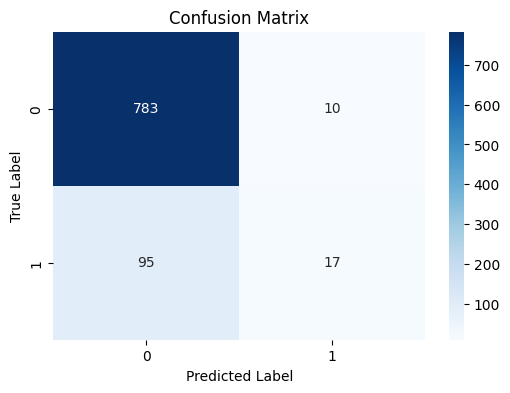

In [59]:
# benchmark classifier weight= 1

clf=models[weights[0]]
pred_ = clf.predict(X_test)
plot_confusion_matrix(y_test,pred_,class_names=[0,1])

Classification matrix for best weighted model


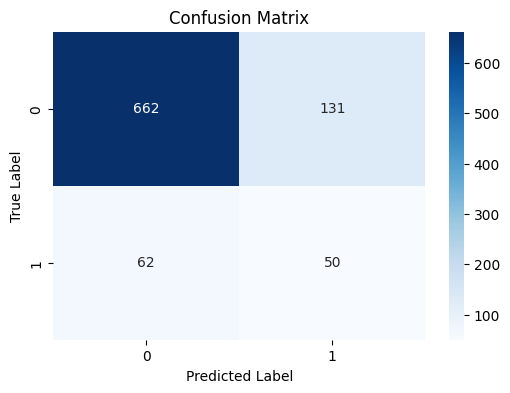

In [60]:
pred = best_clf.predict(X_test)
print('Classification matrix for best weighted model')
plot_confusion_matrix(y_test,pred,class_names=[0,1])

In [89]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.87       793
           1       0.31      0.55      0.40       112

    accuracy                           0.79       905
   macro avg       0.62      0.69      0.64       905
weighted avg       0.85      0.79      0.82       905



Classification matrix for feature selection model


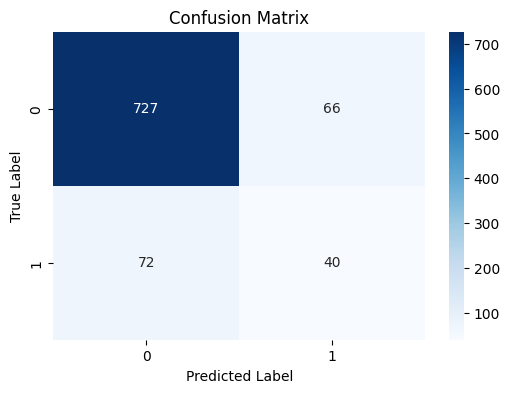

In [65]:
pred_feat=best_clf_feat_selec.predict(X_test_feat_selec)
print('Classification matrix for feature selection model')
plot_confusion_matrix(y_test_feat_selec,pred_feat,class_names=[0,1])

Classification matrix for SMOTE


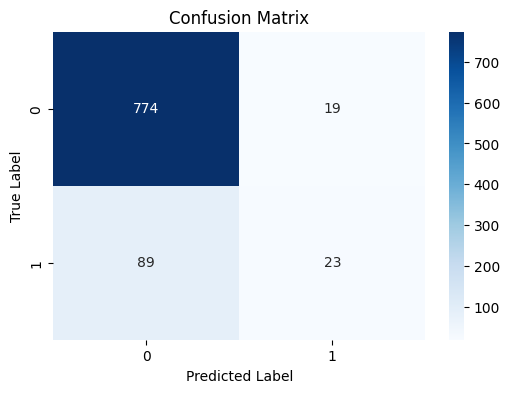

In [57]:
pred_SMOTE = xgb_model_smote.predict(X_test)
print('Classification matrix for SMOTE')
plot_confusion_matrix(y_test,pred_SMOTE, class_names=['0','1'])


In [64]:
print('Classification report for benchmark model (weight=1)')
print(classification_report(y_test,pred_))

Classification report for benchmark model (weight=1)
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       793
           1       0.63      0.15      0.24       112

    accuracy                           0.88       905
   macro avg       0.76      0.57      0.59       905
weighted avg       0.86      0.88      0.85       905



In [62]:
print('Classification report for weighted model')
print(classification_report(y_test,pred))

Classification report for weighted model
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       793
           1       0.28      0.45      0.34       112

    accuracy                           0.79       905
   macro avg       0.60      0.64      0.61       905
weighted avg       0.84      0.79      0.81       905



In [63]:
print('Classification report for features selected model')
print(classification_report(y_test_feat_selec,pred_feat))


Classification report for features selected model
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       793
           1       0.38      0.36      0.37       112

    accuracy                           0.85       905
   macro avg       0.64      0.64      0.64       905
weighted avg       0.84      0.85      0.85       905



From the classifiers we have tested, the most accurate on the test sample is the one with weight=100.